# <img src="https://drive.google.com/uc?id=1aqzJKccKhSSa5033NqjP8sFnoLE3YxZ-" alt="banner" style="width:700px;">


## Fuentes de Datos
Nuestra fuente de datos proviene de [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset#True.csv), el contenido se compone de dos dataset (Fake y True) los cuales poseen informacion sobre noticias entre el 2015 y 2018. Estos datasets se componen de 4 columnas cada uno y un total de 44898 filas. \\
Las columnas son:
- **`[title]`** - contiene el titulo de la noticia
- **`[text]`** - contiene el cuerpo de las noticia y en el caso de las noticias verdaderas tambien contiene una ubicacion y un actor
- **`[subject]`** - contiene el tipo de noticia
- **`[date]`** - contiene la fecha en la que fue escrita la noticia

In [ ]:
#MONTAR EL DRIVE
import os
import errno
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Clasificador de noticias')
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Universidad/SEMESTRE 9/Inteligencia Artificial/Clasificador de noticias


In [ ]:
#Load lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras

In [ ]:
# Creación de carpetas
try:
    os.mkdir('DatasetsModificado')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
try:
    os.mkdir('DatasetsTrainAndTest')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
try:
    os.mkdir('ModelosEntrenados')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## Extracción del Dataset y Analisis exploratorio

In [ ]:
fake = pd.read_csv('DatasetsOriginales/Fake.csv')
real = pd.read_csv('DatasetsOriginales/True.csv')
print('Filas y columnas del dataset Fake ', fake.shape)
print('Filas y columnas del dataset True ', real.shape)

Filas y columnas del dataset Fake  (23481, 4)
Filas y columnas del dataset True  (21417, 4)


In [ ]:
fake.head()

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [ ]:
real.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

El dataset de noticias verdaderas contiene una información que puede generar problemas al momento de realizar el analisis del texto, al mirar la columna text vemos que las noticias verdaderas inician con una ubicación y un editor mientras las falsas no, asi que quitaremos esa información para no tener problemas de consistencias al momento de analizar las cantidad de letras o caracteres que contiene el cuerpo.

In [ ]:
real['text'] = real['text'].apply(lambda i: i.partition('-')[2])
real['text']

0         The head of a conservative Republican faction...
1         Transgender people will be allowed for the fi...
2         The special counsel investigation of links be...
3         Trump campaign adviser George Papadopoulos to...
4         President Donald Trump called on the U.S. Pos...
                               ...                        
21412     NATO allies on Tuesday welcomed President Don...
21413     LexisNexis, a provider of legal, regulatory a...
21414     In the shadow of disused Soviet-era factories...
21415     Vatican Secretary of State Cardinal Pietro Pa...
21416     Indonesia will buy 11 Sukhoi fighter jets wor...
Name: text, Length: 21417, dtype: object

In [ ]:
fake.dtypes

title      object
text       object
subject    object
date       object
dtype: object

In [ ]:
real.dtypes

title      object
text       object
subject    object
date       object
dtype: object

In [ ]:
real.describe()

title  ...                date
count                                               21417  ...               21417
unique                                              20826  ...                 716
top     Factbox: Trump fills top jobs for his administ...  ...  December 20, 2017 
freq                                                   14  ...                 182

[4 rows x 4 columns]

In [ ]:
fake.describe()

title  ...          date
count                                               23481  ...         23481
unique                                              17903  ...          1681
top     MEDIA IGNORES Time That Bill Clinton FIRED His...  ...  May 10, 2017
freq                                                    6  ...            46

[4 rows x 4 columns]

#### Analisis del cuerpo de la noticia `text`

In [ ]:
nwordFake = fake['text'].apply(len)
nwordReal = real['text'].apply(len)

In [ ]:
nwordFake.describe()

count    23481.000000
mean      2547.396235
std       2532.884399
min          1.000000
25%       1433.000000
50%       2166.000000
75%       3032.000000
max      51794.000000
Name: text, dtype: float64

In [ ]:
nwordReal.describe()

count    21417.000000
mean      2360.217397
std       1683.386696
min          0.000000
25%        888.000000
50%       2200.000000
75%       3213.000000
max      29770.000000
Name: text, dtype: float64

notamos que tanto en el dataset de noticias falsas y el dataset de noticias reales, se presentan datos ilogicos, como que una noticia contiene una longitud de 0 de caracteres en su cuerpo o que solo contiene 1 en su longitud de caracteres.

In [ ]:
real[nwordReal == 0].shape

(2, 4)

In [ ]:
fake[nwordFake == 1].shape

(626, 4)

In [ ]:
real[nwordReal == 0]['text'].values

array(['', ''], dtype=object)

In [ ]:
fake[nwordFake == 1]['text'].values

array([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' 

Al imprimir los valores donde se presentan los valores ilogicos en el numero de caracteres, notamos que estas son cadedas vacias, por lo tanto las eliminaremos

In [ ]:
# removemos las filas que presentan estos valores ilogicos
real = real[nwordReal != 0]
fake = fake[nwordFake != 1]

In [ ]:
nwordFake = nwordFake[nwordFake != 1]

In [ ]:
nwordReal = nwordReal[nwordReal != 0]

In [ ]:
print('Longitud noticias falsas: ', fake.shape)
print('longitud noticias verdaderas: ',real.shape)

Longitud noticias falsas:  (22855, 4)
longitud noticias verdaderas:  (21415, 4)


In [ ]:
# Descripcion de numeros de palabras de noticias falsas
nwordFake.describe()

count    22855.000000
mean      2617.142201
std       2531.552645
min          2.000000
25%       1516.500000
50%       2199.000000
75%       3058.000000
max      51794.000000
Name: text, dtype: float64

In [ ]:
nwordReal.describe()

count    21415.000000
mean      2360.437824
std       1683.310758
min         46.000000
25%        889.000000
50%       2200.000000
75%       3213.500000
max      29770.000000
Name: text, dtype: float64

Notamos que siguen presentando inconsistencias en los valores de la cantidad de caracteres de las noticias, asi que realizaremos un analisis mas profundo en el cuerpo de estas. \\

In [ ]:
fake[nwordFake == 2]['text']

12244      
12654      
16306      
19756      
Name: text, dtype: object

In [ ]:
real[nwordReal == 46]['text']

6026    - Source link: bit.ly/2jpy49U; bit.ly/2jpEXYR 
Name: text, dtype: object

Se evidencia que al revisar los valores minimos en la longitud, vemos que estos presentan algunos links o estan vacios, por lo tanto estableceremos que si una noticia no contiene una longitud de 100 caracteres (longitud maxima en promedio que permite cualquier red social en sus publicaciones) la removeremos para que esto no interfiera en el analisis del texto.

In [ ]:
fake[nwordFake < 100].shape

(413, 4)

In [ ]:
real[nwordReal < 100].shape

(2, 4)

In [ ]:
real = real[nwordReal >= 100]
fake = fake[nwordFake >= 100]
print('Longitud noticias falsas: ', fake.shape)
print('longitud noticias verdaderas: ',real.shape)

Longitud noticias falsas:  (22442, 4)
longitud noticias verdaderas:  (21413, 4)


In [ ]:
nwordFake = nwordFake[nwordFake >= 100]
nwordReal = nwordReal[nwordReal >= 100]

In [ ]:
nwordReal.describe()

count    21413.000000
mean      2360.653855
std       1683.240933
min        110.000000
25%        890.000000
50%       2200.000000
75%       3214.000000
max      29770.000000
Name: text, dtype: float64

In [ ]:
nwordFake.describe()

count    22442.000000
mean      2664.291151
std       2530.546595
min        100.000000
25%       1574.000000
50%       2223.000000
75%       3078.750000
max      51794.000000
Name: text, dtype: float64

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(nwordReal.values, bins=30)
plt.title("Noticias verdaderas")
plt.xlabel("Numeros de letras en text")
plt.subplot(122)
plt.hist(nwordFake.values, bins=30)
plt.title("Noticias Falsas")
plt.xlabel("Numeros de letras en text")

Text(0.5, 0, 'Numeros de letras en text')

Notamos que la cantidad de caracteres en el cuerpo de la noticia es un factor influyente al determinar si la noticia es falsa y verdadera, por lo general las noticias falsas suelen ser mas extensas que las noticias verdaderas en promedio.

#### Analisis de los titulos `title`

In [ ]:
nwordFakeT = fake['title'].apply(len)
nwordRealT = real['title'].apply(len)

In [ ]:
nwordFakeT.describe()

count    22442.000000
mean        94.271322
std         27.257271
min          8.000000
25%         77.000000
50%         90.000000
75%        105.000000
max        286.000000
Name: title, dtype: float64

In [ ]:
nwordRealT.describe()

count    21413.000000
mean        64.669406
std          9.165138
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: title, dtype: float64

Text(0.5, 0, 'Numeros de letras en tittle')

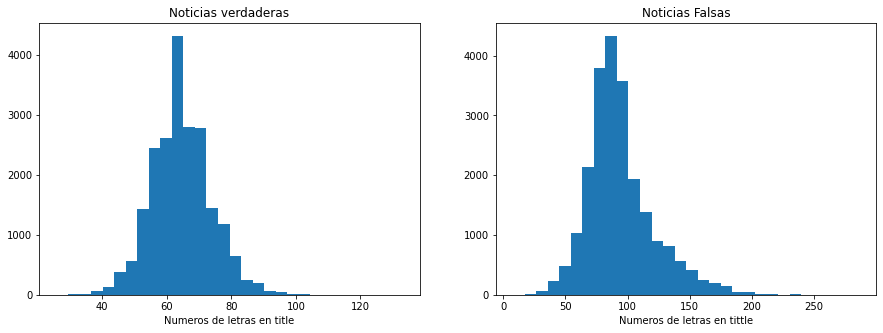

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(nwordRealT.values, bins=30)
plt.title("Noticias verdaderas")
plt.xlabel("Numeros de letras en title")
plt.subplot(122)
plt.hist(nwordFakeT.values, bins=30)
plt.title("Noticias Falsas")
plt.xlabel("Numeros de letras en tittle")

Notamos tambien que el titulo tiene un efecto parecido que al del cuerpo, en promedio las noticias falsas presentan una extencion de texto en el titulo mayor que las noticas verdaderas

#### Analisis de la variable `subject`

In [ ]:
print('Categorias noticias falsas', fake['subject'].unique())
print('Categorias noticas verdaderas', real['subject'].unique())

Categorias noticias falsas ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
Categorias noticas verdaderas ['politicsNews' 'worldnews']


Notamos que la columna `subject` presenta cierta incosistencia y no tiene claridad. Ademas las notamos que las categorias estan nombradas de forma diferente, mientras que en las noticias verdaderas solo existen dos clases de forma general, en las noticias falsas tienen una división mas concreta. Por lo tanto elinaremos esta columna con el fin de no generar problemas en la clasificación

In [ ]:
fake.drop("subject", axis=1, inplace=True)
real.drop("subject", axis=1, inplace=True)

In [ ]:
fake.head(2)

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017

[2 rows x 3 columns]

In [ ]:
real.head(2)

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 

[2 rows x 3 columns]

In [ ]:
real['label'] = 1
fake['label'] = 0

In [ ]:
fake.to_csv('DatasetsModificado/fakeModifcado.csv')

In [ ]:
real.to_csv('DatasetsModificado/realModifcado.csv')

#### Union de los dataset
Antes de iniciar el proceso para tokenizar las palabras, uniremos los datasets en uno solo.

In [ ]:
news = pd.concat((real, fake)).sample(frac=1).reset_index(drop=True)

In [ ]:
news.head()

title  ... label
0  British foreign minister arrives in U.S. to me...  ...     1
1  Swiss war crimes inquiry into Assad's uncle st...  ...     1
2  Supreme Court rejects U.S. senator's bid to es...  ...     1
3  Russia, Jordan agree to speed de-escalation zo...  ...     1
4  TRUMP EXPOSES TRUTH ABOUT WHY U.S. STATE DEPT ...  ...     0

[5 rows x 4 columns]

In [ ]:
news.tail()

title  ... label
43850  Republican Marco Rubio not making a play for 2...  ...     1
43851  Obama, Mexico's Pena Nieto discuss U.S.-Mexico...  ...     1
43852  European businesses working in Russia slam pro...  ...     1
43853  WATCH WHAT HAPPENS WHEN CHRISTIAN MAN ASKS 13 ...  ...     0
43854  Rosy White House tax cut forecast clashes with...  ...     1

[5 rows x 4 columns]

In [ ]:
news.shape

(43855, 4)

In [ ]:
news.to_csv('DatasetsModificado/news.csv')

## Embedding

In [ ]:
%run Embeddings.py
news = pd.read_csv('DatasetsModificado/news.csv')
news.drop(columns=['Unnamed: 0'], inplace = True)
embedding(news)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Limpieza completada
Vectorizacion completada
title vectorizado
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Limpieza completada
Vectorizacion completada
text vectorizado


## Clasificación

### Analisis de clasificadores

Primero analizaremos los resultados obtenidos con los siguientes clasificadores: 
- `DecicionTreeClassifier` max_def=200
- `Support vector machine` kernel='rbf', C=1.0, gamma=0.7 y random_state=1
- `RandomForest` n_estimators=200 y max_def=200

In [ ]:
# Labels
y_train = pd.read_csv('DatasetsTrainAndTest/labels_entrenamiento.csv')
y_test = pd.read_csv('DatasetsTrainAndTest/labels_testeo.csv')

# Titles 
titles_train = pd.read_csv('DatasetsTrainAndTest/titles_entrenamiento.csv')
titles_test = pd.read_csv('DatasetsTrainAndTest/titles_testeo.csv')

# Cuerpo 
cuerpo_train = pd.read_csv('DatasetsTrainAndTest/cuerpo_entrenamiento.csv')
cuerpo_test = pd.read_csv('DatasetsTrainAndTest/cuerpo_testeo.csv')

In [ ]:
y_train.drop(columns=['Unnamed: 0'], inplace = True)
y_test.drop(columns=['Unnamed: 0'], inplace = True)

titles_train.drop(columns=['Unnamed: 0'], inplace = True)
titles_test.drop(columns=['Unnamed: 0'], inplace = True)

cuerpo_train.drop(columns=['Unnamed: 0'], inplace = True)
cuerpo_test.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
def fit_estimador( data_train, data_test, labels_train, labels_test):
  import numpy as np
  import pandas as pd
  import scipy.stats as stats
  from sklearn.model_selection import KFold
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.svm import SVC
  from sklearn.metrics import accuracy_score
  from tqdm.notebook import tnrange
  
  DTC = DecisionTreeClassifier(max_depth=50)
  RFC = RandomForestClassifier(n_estimators=200, max_depth=50)
  SVC_t = SVC(kernel='rbf', random_state=1)
  estimadores = [{'est': DTC, 'score': 0, 'tpr': 0, 'tnr': 0},
                 {'est': RFC, 'score': 0, 'tpr': 0, 'tnr': 0},
                 {'est': SVC_t, 'score': 0, 'tpr': 0, 'tnr': 0},]

  for i in tnrange(len(estimadores)):
    estimadores[i]['est'].fit(data_train, np.ravel(labels_train))
    pred = estimadores[i]['est'].predict(data_test)
    estimadores[i]['score'] = accuracy_score(pred, np.ravel(labels_test))
    estimadores[i]['tpr'] = np.mean(pred[labels_test['label']==0] == labels_test['label'][labels_test['label']==0])
    estimadores[i]['tnr'] = np.mean(pred[labels_test['label']==1] == labels_test['label'][labels_test['label']==1])
  
  return estimadores


#### Clasificacion a partir de la variable title

In [ ]:
titles_estimadores = fit_estimador(titles_train, titles_test, y_train, y_test)
for es in titles_estimadores:
  print(type(es['est']))
  print('score: ', es['score'])
  print('tpr: ', es['tpr'])
  print('tnr: ', es['tnr'])
  print('____________________________________________________________')
  print(' ')


<class 'sklearn.tree._classes.DecisionTreeClassifier'>
score:  0.6538593090867632
tpr:  0.5519235045585946
tnr:  0.761113710809546
____________________________________________________________
 
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
score:  0.6538593090867632
tpr:  0.5519235045585946
tnr:  0.761113710809546
____________________________________________________________
 
<class 'sklearn.svm._classes.SVC'>
score:  0.6538593090867632
tpr:  0.5519235045585946
tnr:  0.761113710809546
____________________________________________________________
 


#### Clasificacion a partir de la variable `text`

In [ ]:
text_estimadores = fit_estimador(cuerpo_train, cuerpo_test, y_train, y_test)
for es in text_estimadores:
  print(type(es['est']))
  print('score: ', es['score'])
  print('tpr: ', es['tpr'])
  print('tnr: ', es['tnr'])
  print('____________________________________________________________')
  print(' ')


<class 'sklearn.tree._classes.DecisionTreeClassifier'>
score:  0.919849504047429
tpr:  0.9366244162775184
tnr:  0.9021993448759944
____________________________________________________________
 
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
score:  0.9691027248888382
tpr:  0.9673115410273516
tnr:  0.970987365465606
____________________________________________________________
 
<class 'sklearn.svm._classes.SVC'>
score:  0.9676205677801847
tpr:  0.9653102068045364
tnr:  0.9700514740290126
____________________________________________________________
 


### Red neuronal

In [ ]:
def red_neuronal(data_train, data_test, labels_train, labels_test):
  import numpy as np
  import pandas as pd
  import tensorflow as tf
  from tensorflow import keras
  X_train = np.asarray(data_train)
  X_test = np.asarray(data_test)
  y_train1 = np.asarray(labels_train)
  y_test1 = np.asarray(labels_test)

  model = keras.models.Sequential([
                 keras.layers.Flatten( input_shape=X_train[0].shape),
                 keras.layers.Dense(4096, activation=tf.nn.relu),
                 keras.layers.Dense(2048, activation=tf.nn.relu),
                 keras.layers.Dense(1024, activation=tf.nn.relu),
                 keras.layers.Dense(512, activation=tf.nn.relu),
                 keras.layers.Dense(10, activation=tf.nn.softmax)
  ])

  model.compile(optimizer=tf.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train1, batch_size=X_train.shape[0], epochs=15, validation_data=(X_test, y_test1))
  test_loss, test_acc = model.evaluate(X_test, y_test1)
  return model, history, test_loss, test_acc

#### Variable `title`

In [ ]:
model_t, historial, test_loss_t, test_acc_t = red_neuronal(titles_train, titles_test, y_train, y_test)

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 2.3028 - accuracy: 0.2168 - val_loss: 2.1284 - val_accuracy: 0.5127
Epoch 2/15
1/1 [==============================] - 3s 3s/step - loss: 2.1220 - accuracy: 0.5112 - val_loss: 1.7527 - val_accuracy: 0.5127
Epoch 3/15
1/1 [==============================] - 3s 3s/step - loss: 1.7347 - accuracy: 0.5112 - val_loss: 1.4862 - val_accuracy: 0.5127
Epoch 4/15
1/1 [==============================] - 3s 3s/step - loss: 1.4712 - accuracy: 0.5112 - val_loss: 1.1618 - val_accuracy: 0.5127
Epoch 5/15
1/1 [==============================] - 3s 3s/step - loss: 1.1481 - accuracy: 0.5112 - val_loss: 0.8742 - val_accuracy: 0.6476
Epoch 6/15
1/1 [==============================] - 3s 3s/step - loss: 0.8631 - accuracy: 0.6543 - val_loss: 0.7088 - val_accuracy: 0.6476
Epoch 7/15
1/1 [==============================] - 3s 3s/step - loss: 0.7038 - accuracy: 0.6543 - val_loss: 0.6807 - val_accuracy: 0.5127
Epoch 8/15
1/1 [=========================

accuracy:  0.5127123594284058  loss:  0.6465772390365601


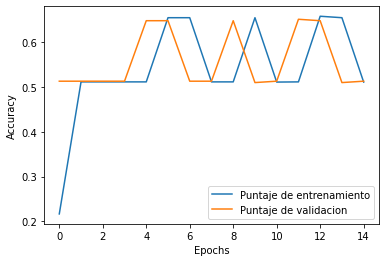

In [ ]:
plt.plot(historial.history['accuracy'], label='Puntaje de entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Puntaje de validacion')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

print('accuracy: ', test_acc_t, ' loss: ', test_loss_t)

#### Variable `text`

In [ ]:
model_c, historial_c, test_loss_c, test_acc_c = red_neuronal(cuerpo_train, cuerpo_test, y_train, y_test)

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 2.3021 - accuracy: 0.1470 - val_loss: 1.7713 - val_accuracy: 0.4874
Epoch 2/15
1/1 [==============================] - 3s 3s/step - loss: 1.7710 - accuracy: 0.4889 - val_loss: 0.8483 - val_accuracy: 0.4873
Epoch 3/15
1/1 [==============================] - 3s 3s/step - loss: 0.8470 - accuracy: 0.4888 - val_loss: 0.7245 - val_accuracy: 0.5127
Epoch 4/15
1/1 [==============================] - 3s 3s/step - loss: 0.7255 - accuracy: 0.5112 - val_loss: 1.6686 - val_accuracy: 0.4873
Epoch 5/15
1/1 [==============================] - 3s 3s/step - loss: 1.6571 - accuracy: 0.4888 - val_loss: 0.6247 - val_accuracy: 0.5133
Epoch 6/15
1/1 [==============================] - 3s 3s/step - loss: 0.6245 - accuracy: 0.5126 - val_loss: 1.0550 - val_accuracy: 0.5127
Epoch 7/15
1/1 [==============================] - 3s 3s/step - loss: 1.0582 - accuracy: 0.5112 - val_loss: 0.5632 - val_accuracy: 0.6482
Epoch 8/15
1/1 [=========================

accuracy:  0.9099304676055908  loss:  0.2770934998989105


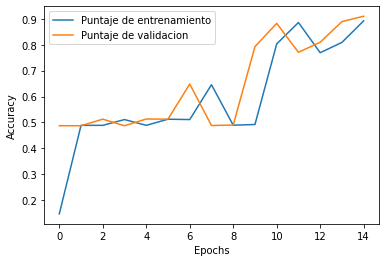

In [ ]:
plt.plot(historial_c.history['accuracy'], label='Puntaje de entrenamiento')
plt.plot(historial_c.history['val_accuracy'], label='Puntaje de validacion')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
print('accuracy: ', test_acc_c, ' loss: ', test_loss_c)

Bueno al analizar los resultados presentados por los diferentes estimadores en cada una de las variables llegamos a las siguientes conclusiones: \\
- Al trabajar solo con la variable `title` encontramos que los puntajes son muy bajos, por lo tanto solo trabajaremos con la variable `text` para realizar el modelo.
- En la variable `text` que corresponde al cuerpo de mensajes vemos que los puntajes presentados estan por encima del 89% presentando una mejor clasificacion al realizar el proceso por medio de esta variable
- De los tres clasificadores y la red neuronal que probamos para la clasificacion, vemos que tanto el Random Forest y la maquina de soporte vectorial presentan los mejores resultados y por motivo de efectivad y tiempo escogeremos el Random Forest para la realizacion del modelo.

In [ ]:
#Exportacion del estimador selecionado
from sklearn.externals import joblib
joblib.dump(text_estimadores[1]['est'], 'ModelosEntrenados/RFC_text_entrenado.pkl')

['ModelosEntrenados/RFC_text_entrenado.pkl']

##Demo

Nota: Para probrar el demo puede descargar los datasets de pruebas en los siguientes enlaces:
- [cuerpo_prueba](https://drive.google.com/file/d/1lhDX9yzDEkEs2v6_RQcDZsw-f-hKLeCs/view?usp=sharing)
- [vocabulario](https://drive.google.com/file/d/1XrucTM7mN8rKzBNo5SCHPoL6KnskWl8a/view?usp=sharing)
- [news](https://drive.google.com/file/d/1Qa0ZfvjO3rgpayroc68BXDUBQvci7WfL/view?usp=sharing)
- [Estimador](https://drive.google.com/file/d/1IUDuNBQ-WpvCLxiGq2jaII3VgUKhIe2v/view?usp=sharing)

In [ ]:
# Cargamos el datasets de pruebas y el dataset news. El datasets de prueba lo utilizaremos
# para encontrar el indice de la noticia que no se encuentra en los datasets de Train y de Test
# para asegurarnos de que el calificador no se aprendio el dataset
cuerpo_prueba = pd.read_csv('DatasetsTrainAndTest/cuerpo_prueba.csv')
cuerpo_prueba.drop(columns=['Unnamed: 0'], inplace = True)
news = pd.read_csv('DatasetsModificado/news.csv')
news.drop(columns=['Unnamed: 0'], inplace = True)
text_array = np.asarray(news['text'])
cuerpo_array = np.asarray(cuerpo_prueba)
vocabu = pd.read_csv('DatasetsTrainAndTest/vocabulario.csv')
vocabu.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
#Funcio para lematizar el texto de la noticia seleccionada
def limpiar_noticia(noticia):
  import numpy as np
  import pandas as pd
  from nltk.stem import WordNetLemmatizer
  from nltk.tokenize import word_tokenize
  import string
  import nltk
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')
  from nltk.corpus import stopwords

  lematizador = WordNetLemmatizer()
  mods = word_tokenize(noticia)
  mods = [mod.lower() for mod in mods if mod.isalpha()]
  mods = [mod for mod in mods if mod not in string.punctuation and mod not in set(stopwords.words('english'))]
  mods = [lematizador.lemmatize(mod) for mod in mods]
  mods = ' '.join(mods)
  
  print('Limpieza completada')
  return mods

# Se vectoriza la noticia
def vectorizacion(noticia, vocabulario):
  import numpy as np
  import pandas as pd
  from sklearn.feature_extraction.text import TfidfVectorizer

  tfidf = TfidfVectorizer(vocabulary=vocabulario)
  noticia_vector = tfidf.fit_transform(noticia).todense()

  print('Vectorizacion completada')
  return noticia_vector

#realizar la prueba a partir del calificador seleccionado
def prueba_clf(noticia):
  from sklearn.externals import joblib
  clf_RFC = joblib.load('ModelosEntrenados/RFC_text_entrenado.pkl')
  prediccion = clf_RFC.predict(noticia)
  print('La noticia es:', 'verdadera' if prediccion[0] == 1 else 'falsa')


In [ ]:
a = text_array.shape[0] - cuerpo_array.shape[0] - 1 # Se escoge el valor inicial del rango 
b = text_array.shape[0] - 1 # Se selecciona el valor final para el rango
n = np.random.randint(a,b)
probar = None
if n != 0:
  n1 = n-1
  probar = text_array[n1:n][0]
else:
  n = n+1
  probar = text_array[:n][0]
probar # para mostrar la noticia que vamos a probar

' Top White House officials met moderate and conservative Republicans in the U.S. House of Representatives on Monday in an effort to revive a plan to repeal and replace Obamacare. Key members of the administration, including Vice President Mike Pence, invited a group of moderate Republicans known as the “Tuesday Group” to the White House. Pence then went to Capitol Hill to meet the Freedom Caucus, a group of House conservatives who last month derailed a healthcare bill backed by President Donald Trump. The White House would like to see a revised bill come up for a vote as early as week’s end, before the House breaks for a spring recess, and the text of the new proposal could be ready some time on Tuesday, lawmakers said. “It was clear the president would be very happy come Friday to have this passed,” said U.S. Representative Chris Collins, a member of the Tuesday Group and a Trump ally.  “This could move fairly quickly,” he said. Just 10 days ago, House Speaker Paul Ryan was forced to

In [ ]:
# Prueba de noticia
probar = input("Escribe la notica a calificar: ")
probar=limpiar_noticia(probar)
probar=vectorizacion([probar], list(vocabu[:0]))
prueba_clf(probar)

Escribe la notica a calificar:  Top White House officials met moderate and conservative Republicans in the U.S. House of Representatives on Monday in an effort to revive a plan to repeal and replace Obamacare. Key members of the administration, including Vice President Mike Pence, invited a group of moderate Republicans known as the “Tuesday Group” to the White House. Pence then went to Capitol Hill to meet the Freedom Caucus, a group of House conservatives who last month derailed a healthcare bill backed by President Donald Trump. The White House would like to see a revised bill come up for a vote as early as week’s end, before the House breaks for a spring recess, and the text of the new proposal could be ready some time on Tuesday, lawmakers said. “It was clear the president would be very happy come Friday to have this passed,” said U.S. Representative Chris Collins, a member of the Tuesday Group and a Trump ally.  “This could move fairly quickly,” he said. Just 10 days ago, House S

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


La noticia es:  verdadera
